Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'DOT1'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2020-08-19,2.787857,3.077784,2.692896,2.900080,2.900080,4.881987e+07,DOT1-USD
2020-08-20,2.896923,3.090093,2.730919,2.875028,2.875028,4.931314e+07,DOT1-USD
2020-08-21,2.878570,4.510613,2.816762,4.484690,4.484690,4.858011e+08,DOT1-USD
2020-08-22,4.487058,4.487058,3.716271,3.967066,3.967066,3.207495e+08,DOT1-USD
2020-08-23,3.987413,4.783158,3.812670,4.602614,4.602614,4.076902e+08,DOT1-USD
...,...,...,...,...,...,...,...
2021-07-03,15.553584,16.579445,15.221813,16.014027,16.014027,7.520759e+08,DOT1-USD
2021-07-04,15.996540,15.996540,14.788740,15.235582,15.235582,8.448446e+08,DOT1-USD
2021-07-05,15.240785,16.162344,15.210810,16.143564,16.143564,1.001573e+09,DOT1-USD
2021-07-06,16.136374,17.674274,16.101463,16.857790,16.857790,1.424248e+09,DOT1-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 323 entries, 2020-08-19 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      303 non-null    float64
 1   high      303 non-null    float64
 2   low       303 non-null    float64
 3   close     303 non-null    float64
 4   adjclose  303 non-null    float64
 5   volume    303 non-null    float64
 6   ticker    323 non-null    object 
 7   spread    303 non-null    float64
dtypes: float64(7), object(1)
memory usage: 22.7+ KB


## Plot the closing value of Polkadot over time

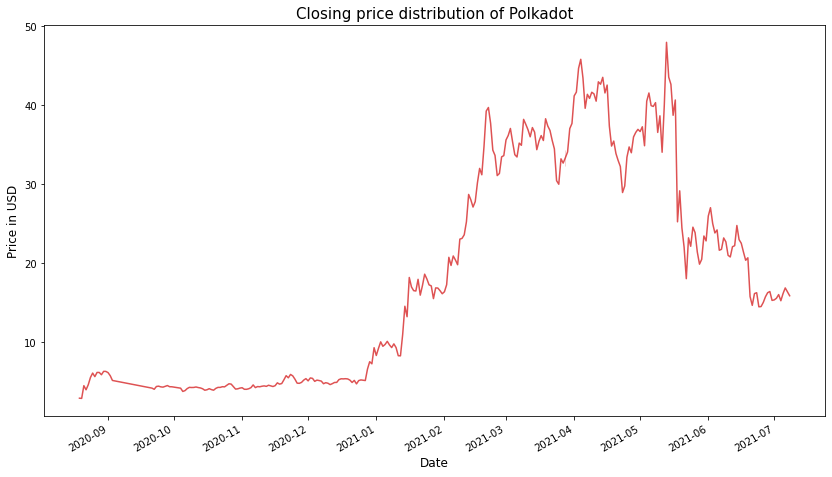

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Polkadot", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Polkadot')

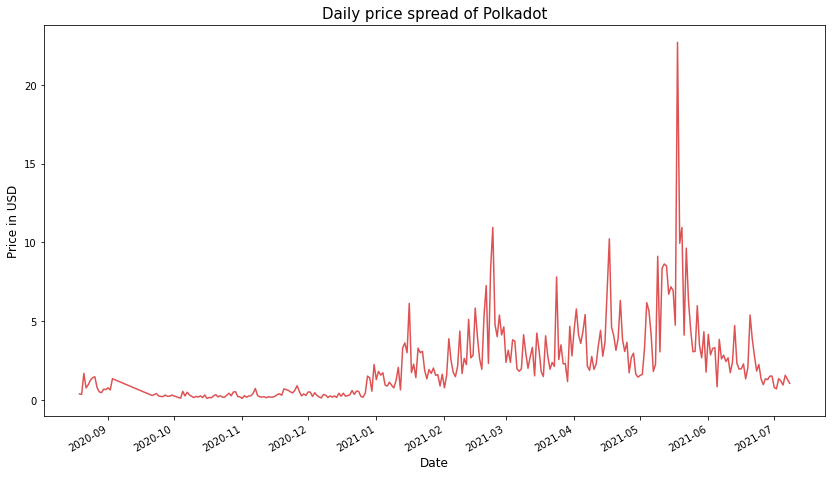

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Polkadot", fontsize=15)

## Candlestick chart

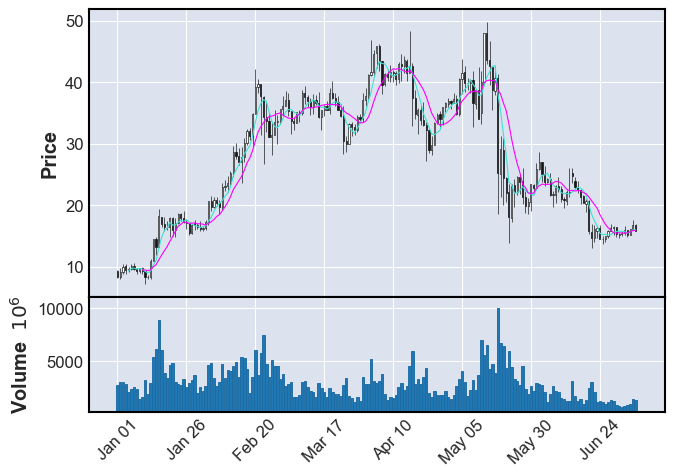

In [11]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2020-08-19,2.900080
1,2020-08-20,2.875028
2,2020-08-21,4.484690
3,2020-08-22,3.967066
4,2020-08-23,4.602614
...,...,...
318,2021-07-03,16.014027
319,2021-07-04,15.235582
320,2021-07-05,16.143564
321,2021-07-06,16.857790


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
347,2021-08-03,1.020424,-3.475176,5.922884
348,2021-08-04,0.845649,-4.041439,5.944843
349,2021-08-05,0.322034,-4.643195,4.817757
350,2021-08-06,-0.181820,-5.627485,5.190969
351,2021-08-07,-0.385302,-5.293782,4.893014


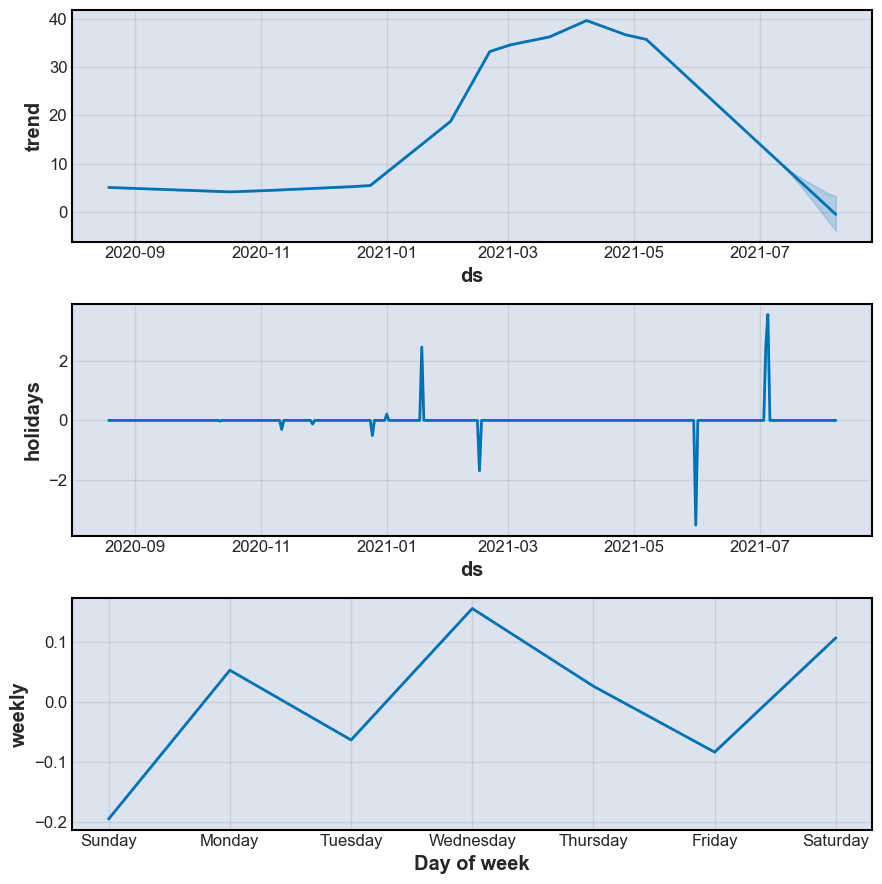

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

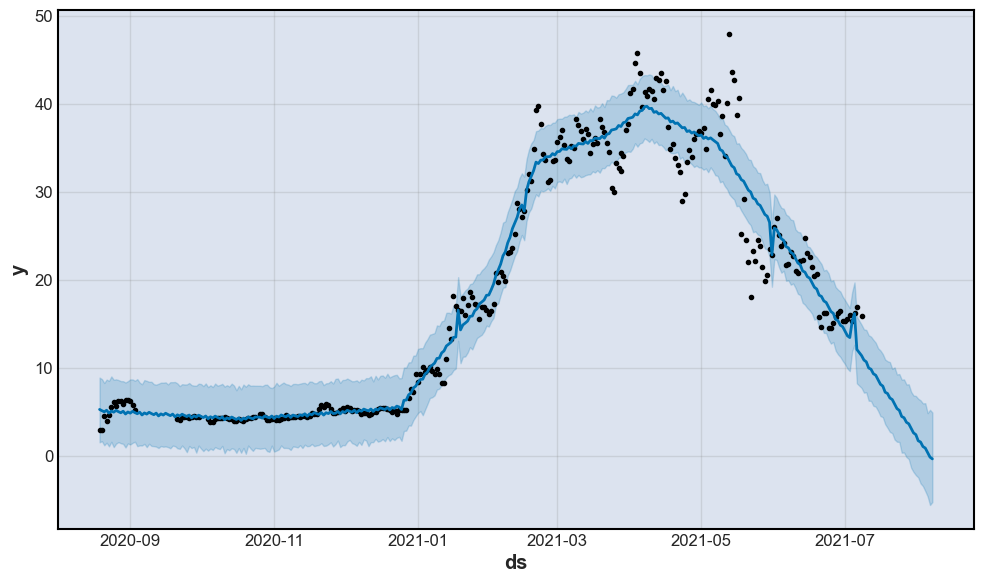

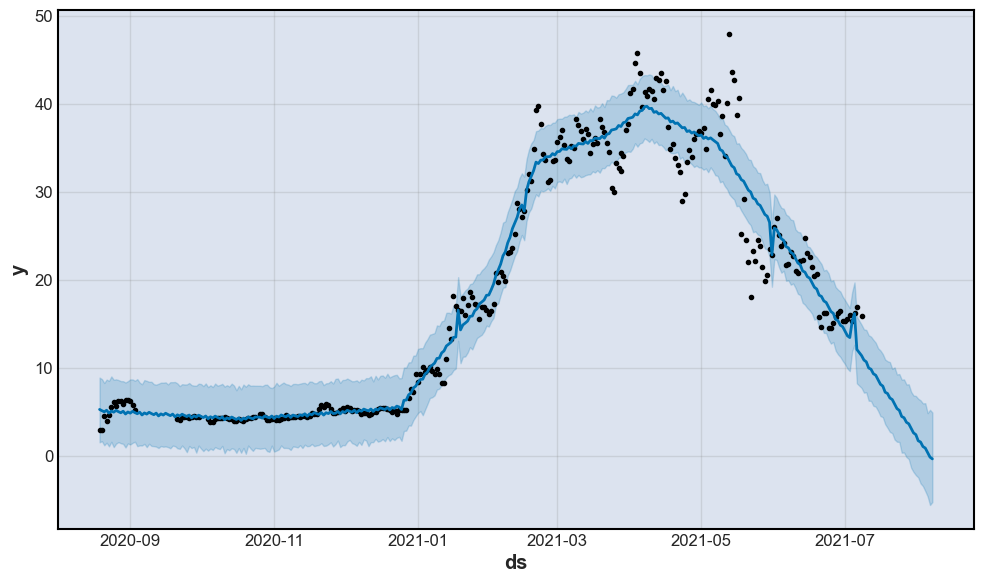

In [10]:
m.plot(forecast)